# DA5401 A3: Addressing Class Imbalance with Clustering and Resampling

## Objective: 
This assignment aims to challenge your understanding of class imbalance,
unsupervised learning (clustering), and its application in improving the performance of a
supervised classification model. You will use clustering to create a more representative training
set for both the minority and majority classes through oversampling and undersampling, and
assess the impact on a Logistic Regression classifier.

## Problem Statement
You are working for a fraud detection company. You've been given a highly imbalanced credit
card transaction dataset where a very small fraction of transactions are fraudulent (the minority
class). Standard classification algorithms often perform poorly on such datasets, as they tend to
classify most instances as the majority class to achieve high overall accuracy, ignoring the
minority class.
Your task is to utilize clustering-based oversampling and clustering-based undersampling
to create a more representative and improved training sample. You will then compare the
performance of a Logistic Regression classifier on four different training sets: the original
imbalanced data, data balanced using a naive oversampling method (SMOTE), data balanced
using a clustering-based oversampling approach (CBO), and data balanced using a
clustering-based undersampling approach (CBU).
You will submit a Jupyter Notebook with your complete code, visualizations, and a plausible
story that explains your findings. The notebook should be well-commented, reproducible, and
easy to follow.
Dataset: The dataset is available on Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [1]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import pairwise_distances


### Part A: Data Exploration and Baseline Model

In [2]:
# 1. Load and Analyze the Dataset: Load the creditcard.csv dataset. This dataset has already been pre-processed using PCA, so no feature engineering is required.
credit_card_data = pd.read_csv('creditcard.csv')
print(credit_card_data.head())
print(credit_card_data.info())
print(credit_card_data.describe())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

- Based on the above details of the dataset, the dataset has 284,807 rows and 31 columns, all numeric, with no missing values.
- Most feature columns (V1–V28) are standardized and centered around zero, likely from PCA transformation.
- The "Time" column ranges from 0 to ~172,792 seconds, while the "Amount" column is highly skewed, varying from 0 to 25,691.
- The "Class" column is extremely imbalanced, with only about 0.17% fraud cases (1) compared to the majority of legitimate ones (0).

Imbalance Ratio (Non-Fraud:Fraud) = 577.88:1
Class Distribution:
Non-Fraudulent transactions: 284315 (99.8273%)
Fraudulent transactions: 492 (0.1727%)


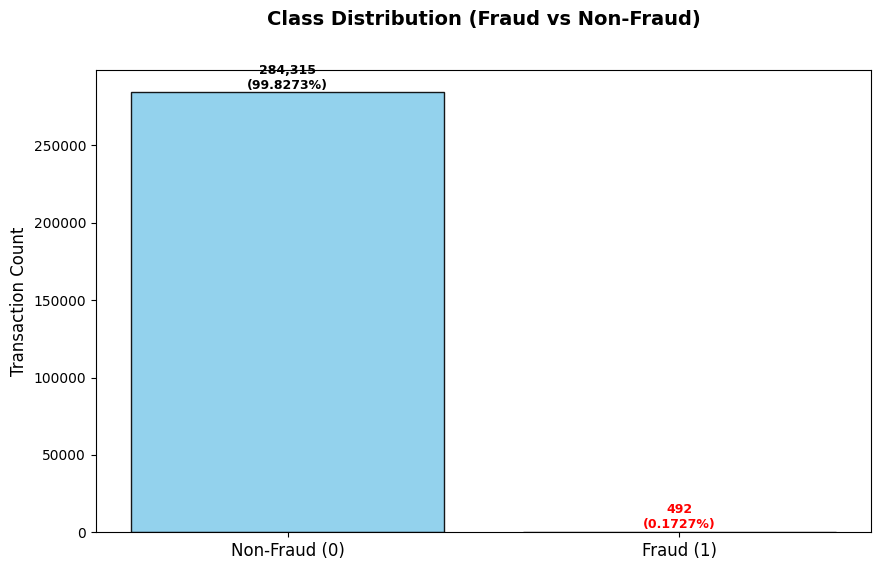

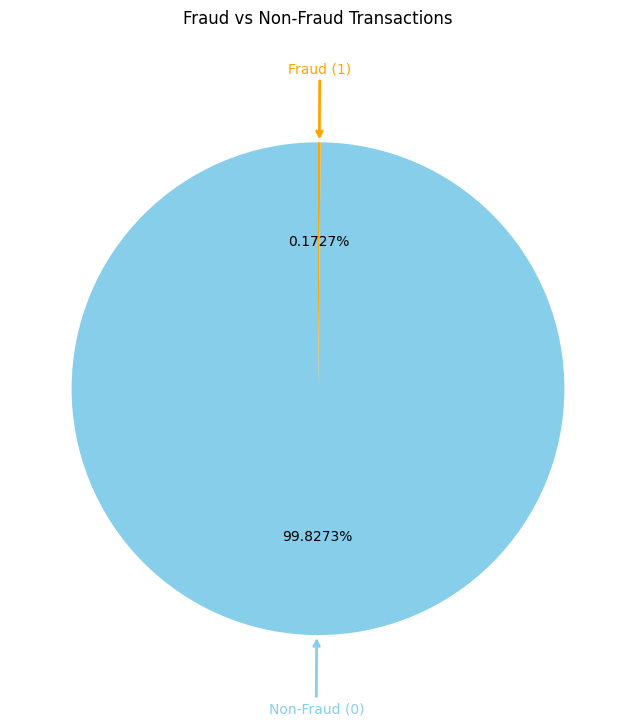

In [3]:
# 2. Analyze Class Distribution: Print the class distribution (count of fraudulent vs non-fraudulent transactions). A pie chart or bar plot would be a good visualization. Clearly state the degree of imbalance.

class_counts = credit_card_data['Class'].value_counts()
non_fraud = class_counts[0]
fraud = class_counts[1]
imbalance_ratio = non_fraud / fraud
labels = ['Non-Fraud (0)', 'Fraud (1)']
bar_colors = ['skyblue', 'red']
pie_colors = ['skyblue', 'orange']
total = len(credit_card_data)

print(f'Imbalance Ratio (Non-Fraud:Fraud) = {imbalance_ratio:.2f}:1')
print("Class Distribution:")
print(f"Non-Fraudulent transactions: {non_fraud} ({non_fraud/total*100:.4f}%)")
print(f"Fraudulent transactions: {fraud} ({fraud/total*100:.4f}%)")

plt.figure(figsize=(10,6))
bars = plt.bar(class_counts.index, class_counts.values, 
               color=bar_colors, edgecolor='black', alpha=0.9)

plt.xticks(ticks=[0,1], labels=labels, fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)
plt.title("Class Distribution (Fraud vs Non-Fraud)", 
          fontsize=14, fontweight='bold', y=1.08)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = (height/total)*100
    plt.text(bar.get_x() + bar.get_width()/2, 
             height + total*0.001,
             f"{height:,}\n({pct:.4f}%)",
             ha='center', va='bottom', fontsize=9,
             color='black' if i==0 else 'red', fontweight='bold')

plt.show()


plt.figure(figsize=(8,8))
wedges, texts, autotexts = plt.pie(
    class_counts,
    autopct='%1.4f%%',
    startangle=90,
    colors=pie_colors
)

# Add labels with arrows dynamically
for i, wedge in enumerate(wedges):
    ang = (wedge.theta2 + wedge.theta1)/2.
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))

    plt.annotate(labels[i],
                 xy=(x, y), xytext=(1.3*x, 1.3*y),
                 arrowprops=dict(arrowstyle="->", 
                                 color=pie_colors[i], lw=2),
                 ha='center', va='center',
                 fontsize=10, color=pie_colors[i])

plt.title("Fraud vs Non-Fraud Transactions", y=1.08)
plt.show()

Class distribution in full dataset:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Class distribution in training set:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64

Class distribution in testing set:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9997    0.9996     56864
           1     0.8193    0.6939    0.7514        98

    accuracy                         0.9992     56962
   macro avg     0.9094    0.8468    0.8755     56962
weighted avg     0.9992    0.9992    0.9992     56962



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


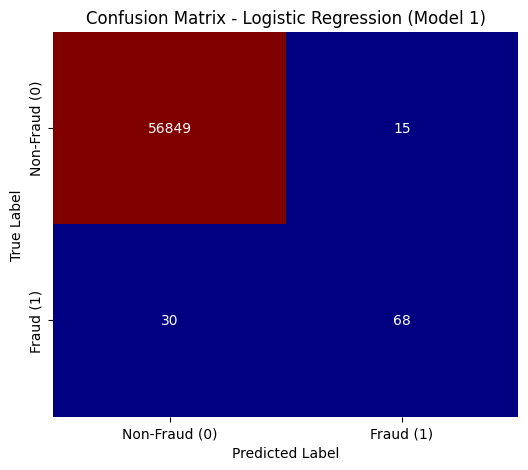

In [3]:
# 3 Baseline Model:

# Split the original dataset into training and testing sets. Crucially, ensure the test set retains its original imbalance.
X = credit_card_data.drop('Class', axis=1)
y = credit_card_data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,   # 20% for testing
    random_state=42, # reproducibility
    stratify=y       # crucial for keeping imbalance ratio
)
print("Class distribution in full dataset:")
print(y.value_counts(normalize=True))

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True))

#Train a Logistic Regression classifier on the imbalanced training data. This will be your Model 1

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

#Evaluate the model's performance on the test set. Pay close attention to metrics robust to imbalance, such as Precision, Recall, and the F1-score for the minority (fraudulent) class.
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="jet", cbar=False,
            xticklabels=["Non-Fraud (0)", "Fraud (1)"],
            yticklabels=["Non-Fraud (0)", "Fraud (1)"])

plt.title("Confusion Matrix - Logistic Regression (Model 1)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

- Explain why accuracy is a misleading metric in this scenario.
    - Accuracy is a misleading metric in this scenario, mainly because of the class imbalance. The model could predict everything as "Non-Fraud" and still achieve ~99.8% accuracy without catching a single fraud.
    - Accuracy = (TP + TN) / Total. With so many true negatives, accuracy looks high. Even then from the above results, we could see that the model has miss classified 30 fraud cases.
    - In fraud detection, the cost of missing a fraud (False Negative) is much higher than the cost of flagging a non-fraud incorrectly (False Positive). Accuracy doesn’t differentiate between these costs — it treats every error equally.

### Part B: Resampling Approaches

In [4]:
#1. Naive Oversampling (SMOTE):

#Apply the SMOTE (Synthetic Minority Over-sampling Technique) algorithm to the training data. This method generates synthetic samples for the minority class.

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class distribution in training set (before SMOTE):")
print(y_train.value_counts())


print("\nClass distribution in training set (after SMOTE):")
print(y_train_smote.value_counts())

Class distribution in training set (before SMOTE):
Class
0    227451
1       394
Name: count, dtype: int64

Class distribution in training set (after SMOTE):
Class
0    227451
1    227451
Name: count, dtype: int64


- Explain how SMOTE works and its potential limitations, such as generating noisy samples if the minority class is not well-defined.
    - SMOTE (Synthetic Minority Over-sampling Technique) balances a dataset by creating new, synthetic samples for the minority class instead of just duplicating existing ones.
        - Pick a minority sample, example: Fraud transaction in our case
        - Find it's K-Nearest neighbors (default k value is 5) within the minority class
        - Randomly select one the neighbors
        - Generate a synthetic sample along the line segment between the original sample and it's neighbor
        - xnew ​= xi​+δ×(xnn​−xi​),∼U(0,1), where xi = original minority sample, xnn = one of it's nearest neighbor, δ = random number between 0 to 1

    - Potential limitations:
        - If the minority class is not well-defined (overlaps heavily with majority class), SMOTE may generate synthetic points inside majority regions, leading to confusing/noisy data.
        - In high-dimensional data, “nearest neighbors” might not be meaningful, and SMOTE can generate unrealistic samples.
        - If the minority class itself is very small or noisy, the model may overfit to those synthetic points.
        - SMOTE assumes minority data is spread uniformly. But in reality, fraud (minority) may consist of different subgroups (e.g., online fraud vs. ATM fraud). SMOTE might generate artificial samples that don’t reflect real-world fraud patterns.
        - Nearest-neighbor searches can be slow on large datasets.

2 Clustering-Based Oversampling:

- Explain the concept of using clustering for oversampling to ensure diversity and explain how it achieves this goal.
    - Problem with naive oversampling:
        - Just duplicates samples → risk of overfitting.
        - Synthetic points may cluster in already dense regions → poor diversity.
    - Clustering-based approach:
        - Cluster the minority class samples (e.g., k-means, DBSCAN).
        - Identify sparse vs. dense regions of the minority class.
        - Generate synthetic samples within clusters, often allocating more to sparse clusters.
    - How it ensures diversity:
        - Distributes new samples across different clusters (subregions).
        - Covers all natural subgroups of the minority class.
        - Avoids concentrating synthetic data in one dense area.
        - Preserves intra-class variance → captures more patterns.
    - Outcome:
        - More diverse and representative minority samples.
        - Better decision boundary coverage.
        - Reduced risk of overfitting and improved generalization.

In [19]:
# Use a clustering algorithm, such as K-Means, to identify a few clusters within the training data of the minority class only. You can choose k based on intuition or the Elbow Method.

X_train_minority = X_train[y_train == 1].copy()
X_train_majority = X_train[y_train == 0].copy()

print(f"Minority samples (fraud): {len(X_train_minority)}")
print(f"Majority samples (non-fraud): {len(X_train_majority)}")

# ---- Step 1: KMeans clustering on minority class ----

k = 4  # this is based on my intuition
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_train_minority)

X_train_minority["cluster"] = clusters

print("Cluster counts in minority class:")
print(pd.Series(clusters).value_counts())

Minority samples (fraud): 394
Majority samples (non-fraud): 227451
Cluster counts in minority class:
2    113
0    111
1     89
3     81
Name: count, dtype: int64


Validating the selection of k using the elbow method:

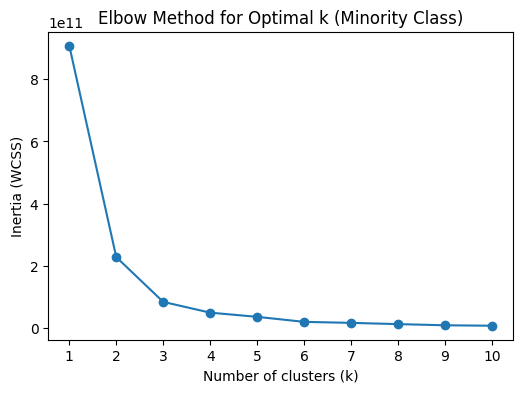

In [20]:
X_train_minority = X_train[y_train == 1]
k_values = range(1, 11)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_minority)
    inertias.append(kmeans.inertia_) 
    
plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o', linestyle='-')
plt.title("Elbow Method for Optimal k (Minority Class)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.xticks(k_values)
plt.show()

In [22]:

print(f"Minority samples (fraud): {len(X_train_minority)}")
print(f"Majority samples (non-fraud): {len(X_train_majority)}")

k = 3  # k selected after looking at the elbow plot
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_train_minority)

X_train_minority = X_train_minority.copy()
X_train_minority["cluster"] = clusters

print("Cluster counts in minority class:")
print(pd.Series(clusters).value_counts())

Minority samples (fraud): 394
Majority samples (non-fraud): 227451
Cluster counts in minority class:
2    146
1    132
0    116
Name: count, dtype: int64


In [23]:
# Oversample from each minority cluster to create a new, balanced dataset. The goal is to ensure that all sub-groups are well-represented, thereby avoiding the creation of synthetic samples in regions with no actual data.

print(f"Minority samples (fraud): {len(X_train_minority)}")
print(f"Majority samples (non-fraud): {len(X_train_majority)}")

total_minority = len(X_train_minority)
total_majority = len(X_train_majority)
target_minority = total_majority 

needed = target_minority - total_minority
print(f"Need to generate {needed} synthetic fraud samples.")

cluster_counts = X_train_minority["cluster"].value_counts().to_dict()
cluster_allocations = {
    c: int(needed * (count / total_minority))
    for c, count in cluster_counts.items()
}

synthetic_samples = []

for c, n_to_generate in cluster_allocations.items():
    cluster_samples = X_train_minority[X_train_minority["cluster"] == c].drop("cluster", axis=1).values
    n_samples = len(cluster_samples)

    if n_samples > 1 and n_to_generate > 0:
        for _ in range(n_to_generate):
            i, j = np.random.choice(n_samples, 2, replace=False)
            lam = np.random.rand()
            new_point = lam * cluster_samples[i] + (1 - lam) * cluster_samples[j]
            synthetic_samples.append(new_point)

X_synthetic = np.array(synthetic_samples)
y_synthetic = np.ones(len(X_synthetic)) 
X_train_balanced = np.vstack([X_train.drop(columns=[], errors="ignore").values, X_synthetic])
y_train_balanced = np.hstack([y_train.values, y_synthetic])

print(f"Final balanced training size: {len(X_train_balanced)}")
print(f"  Non-Fraud: {np.sum(y_train_balanced==0)}")
print(f"  Fraud: {np.sum(y_train_balanced==1)}")


Minority samples (fraud): 394
Majority samples (non-fraud): 227451
Need to generate 227057 synthetic fraud samples.
Final balanced training size: 454900
  Non-Fraud: 227451
  Fraud: 227449


3. Clustering-Based Undersampling (CBU):

- Explain the concept of using clustering for undersampling. The idea is to find sub-groups within the majority class and strategically remove instances to maintain a representative sample while reducing its size.

    - Problem
        - In imbalanced datasets, the majority class (e.g., “non-fraud”) dominates.
        - Training directly on such data often causes the model to be biased toward the majority.
        - Random undersampling can reduce imbalance, but risks discarding important patterns in the majority class.
    - Idea: Clustering-Based Undersampling
        - Instead of removing majority samples randomly, we use clustering to perform undersampling strategically.
        - Steps:
            - Cluster the majority class samples
            - Use a clustering algorithm such as K-Means.
            - Each cluster represents a sub-group within the majority class.
            - Select representative samples from each cluster
            - Keep only a subset of points from each cluster.
            - The number of points chosen can be proportional to the cluster’s size.
            - Discard the rest
    - Reduces the overall size of the majority class while still preserving diversity.
    - Why This Helps
        - Preserves diversity: All sub-groups of the majority class remain represented.
        - Avoids bias: Prevents the model from focusing only on dense regions of the majority class.
        - Reduces redundancy: Removes duplicate or highly similar samples common in large majority classes.
    - Example
        - Suppose the majority class = "Non-fraud transactions":
        - Cluster 1 → Grocery purchases
        - Cluster 2 → Online shopping
        - Cluster 3 → ATM withdrawals
        - Instead of randomly deleting samples, CBU selects a representative subset from each cluster.
        - This ensures the dataset remains balanced and representative.
    - Outcome
        - A smaller, more balanced dataset.
        - Faster training.
        - Better generalization since the majority class retains its internal diversity.


In [24]:
# Use a clustering algorithm to find clusters within the training data of the majority class only.

k_optimal = 3
kmeans_majority = KMeans(n_clusters=k_optimal, random_state=42)
majority_clusters = kmeans_majority.fit_predict(X_train_majority)

# Add cluster labels to majority samples (for inspection)
X_train_majority_clustered = X_train_majority.copy()
X_train_majority_clustered['Cluster'] = majority_clusters

print("Cluster counts in majority class:")
print(pd.Series(majority_clusters).value_counts())


Cluster counts in majority class:
1    102848
0     67461
2     57142
Name: count, dtype: int64


In [32]:
# Undersample from each cluster. For instance, you could remove samples from clusters that are closer to the minority class, or you could simply undersample each cluster proportionally to its size to preserve the original distribution of the majority class.

X_train_minority = X_train[y_train == 1]
X_train_majority = X_train[y_train == 0]

# Cluster majority class
k = 3
kmeans_majority = KMeans(n_clusters=k, random_state=42)
clusters = kmeans_majority.fit_predict(X_train_majority)
target_majority_size = len(X_train_minority)
undersampled_X, undersampled_y = [], []

for cluster_id in np.unique(clusters):
    cluster_samples = X_train_majority[clusters == cluster_id]
    cluster_size = len(cluster_samples)
    cluster_target_size = int((cluster_size / len(X_train_majority)) * target_majority_size)
    X_cluster_resampled = resample(
        cluster_samples,
        replace=False,
        n_samples=cluster_target_size,
        random_state=42
    )
    undersampled_X.append(X_cluster_resampled)
    undersampled_y.extend([0] * cluster_target_size)

X_train_cbu = np.vstack([*undersampled_X, X_train_minority])
y_train_cbu = np.hstack([undersampled_y, np.ones(len(X_train_minority))])

print("Proportional CBU -> Majority:", np.sum(y_train_cbu == 0), 
      " Minority:", np.sum(y_train_cbu == 1))


Proportional CBU -> Majority: 392  Minority: 394


In [33]:

X_train_minority_np = X_train_minority.to_numpy()
X_train_majority_np = X_train_majority.to_numpy()
minority_center = np.mean(X_train_minority_np, axis=0)
cluster_centers = kmeans_majority.cluster_centers_
distances = pairwise_distances(cluster_centers, minority_center.reshape(1, -1)).flatten()
inv_distances = 1 / (distances + 1e-6)  
sampling_weights = inv_distances / inv_distances.sum()

target_majority_size = len(X_train_minority_np)

undersampled_X, undersampled_y = [], []

for cluster_id in np.unique(clusters):
    cluster_samples = X_train_majority_np[clusters == cluster_id]
    cluster_size = len(cluster_samples)
    cluster_target_size = int(sampling_weights[cluster_id] * target_majority_size)
    cluster_target_size = min(cluster_target_size, cluster_size)  # safety

    X_cluster_resampled = resample(
        cluster_samples,
        replace=False,
        n_samples=cluster_target_size,
        random_state=42
    )

    undersampled_X.append(X_cluster_resampled)
    undersampled_y.extend([0] * cluster_target_size)

X_train_cbu_dist = np.vstack([*undersampled_X, X_train_minority_np])
y_train_cbu_dist = np.hstack([undersampled_y, np.ones(len(X_train_minority_np))])

print("Distance-based CBU -> Majority:", np.sum(y_train_cbu_dist == 0), 
      " Minority:", np.sum(y_train_cbu_dist == 1))

Distance-based CBU -> Majority: 393  Minority: 394


The final training set will comprise all instances of the minority class and the
selected subset of majority class instances.

### Part C: Model Comparison and Analysis

In [34]:
# 1. Train and Evaluate Models:

results = {}

# Model 2 (SMOTE): Train a Logistic Regression classifier on the training data balanced with SMOTE. Evaluate its performance on the same, imbalanced test set from Part A.

# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train) # Already done in PART B, can uncomment if you want to redo it
log_reg_smote = LogisticRegression(max_iter=1000, random_state=42)
log_reg_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = log_reg_smote.predict(X_test)

print("\nModel 2 (SMOTE):")
print(classification_report(y_test, y_pred_smote, digits=4))

report_smote = classification_report(y_test, y_pred_smote, output_dict=True)
results["SMOTE"] = report_smote["1"]  # minority class metrics


Model 2 (SMOTE):
              precision    recall  f1-score   support

           0     0.9998    0.9883    0.9940     56864
           1     0.1166    0.8980    0.2063        98

    accuracy                         0.9881     56962
   macro avg     0.5582    0.9431    0.6002     56962
weighted avg     0.9983    0.9881    0.9927     56962



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Model 3 (CBO): Train a Logistic Regression classifier on the training data balanced with your clustering-based oversampling approach. Evaluate its performance on the same, imbalanced test set.

log_reg_cbo = LogisticRegression(max_iter=1000, random_state=42)
log_reg_cbo.fit(X_train_balanced, y_train_balanced)   # from PART B
y_pred_cbo = log_reg_cbo.predict(X_test)

print("\nModel 3 (CBO):")
print(classification_report(y_test, y_pred_cbo, digits=4))
report_cbo = classification_report(y_test, y_pred_cbo, output_dict=True)
results["CBO"] = report_cbo["1"]


Model 3 (CBO):
              precision    recall  f1-score   support

           0     0.9998    0.9878    0.9938     56864
           1     0.1124    0.8980    0.1998        98

    accuracy                         0.9876     56962
   macro avg     0.5561    0.9429    0.5968     56962
weighted avg     0.9983    0.9876    0.9924     56962



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [36]:
# Model 4 (CBU): Train a Logistic Regression classifier on the training data balanced with your clustering-based undersampling approach. Evaluate its performance on the same, imbalanced test set.

log_reg_cbu = LogisticRegression(max_iter=1000, random_state=42)
log_reg_cbu.fit(X_train_cbu_dist, y_train_cbu_dist)  # from PART B
y_pred_cbu = log_reg_cbu.predict(X_test)

print("\nModel 4 (CBU):")
print(classification_report(y_test, y_pred_cbu, digits=4))
report_cbu = classification_report(y_test, y_pred_cbu, output_dict=True)
results["CBU"] = report_cbu["1"]


Model 4 (CBU):
              precision    recall  f1-score   support

           0     0.9998    0.9412    0.9697     56864
           1     0.0259    0.9082    0.0505        98

    accuracy                         0.9412     56962
   macro avg     0.5129    0.9247    0.5101     56962
weighted avg     0.9982    0.9412    0.9681     56962



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



Summary Table:
          precision    recall  f1-score
SMOTE      0.116556  0.897959  0.206331
CBO        0.112388  0.897959  0.199773
CBU        0.025948  0.908163  0.050454
Baseline   0.819277  0.693878  0.751381


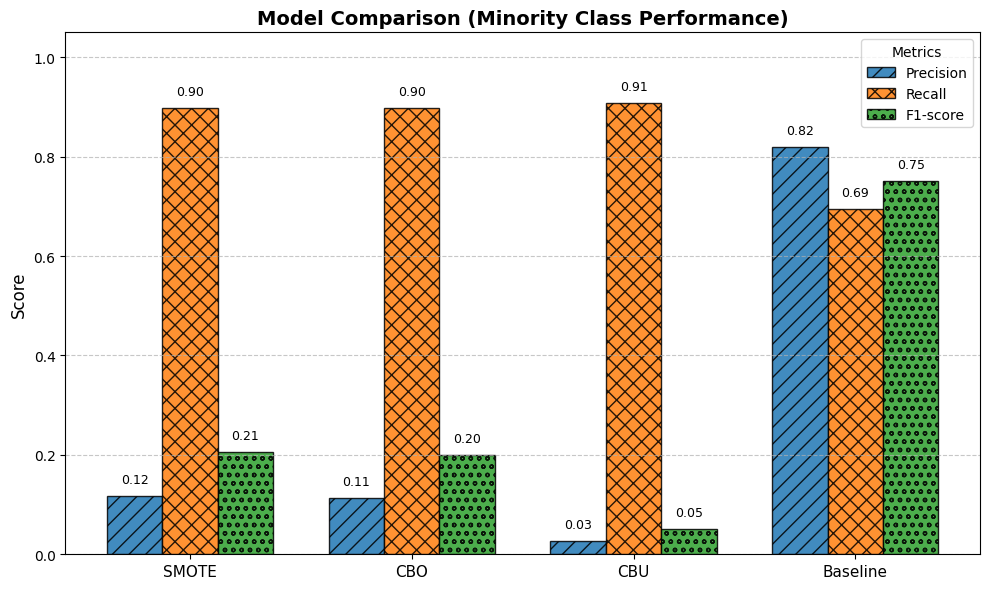

In [43]:
# Performance Comparison: Create a summary table or bar chart comparing the Precision, Recall, and F1-score of the four models (Baseline, SMOTE, CBO, and CBU) for the minority class.

report_baseline = classification_report(y_test, y_pred, output_dict=True)
results["Baseline"] = report_baseline["1"]
results_df = pd.DataFrame(results).T[["precision", "recall", "f1-score"]]

print("\nSummary Table:")
print(results_df)

metrics = ["precision", "recall", "f1-score"]
models = results_df.index
x = np.arange(len(models)) 
width = 0.25  
fig, ax = plt.subplots(figsize=(10,6))
patterns = ["//", "xx", "oo"]

for i, metric in enumerate(metrics):
    ax.bar(
        x + i*width - width, 
        results_df[metric],
        width,
        label=metric.capitalize(),
        alpha=0.85,
        hatch=patterns[i],
        edgecolor="black"
    )

ax.set_title("Model Comparison (Minority Class Performance)", fontsize=14, fontweight="bold")
ax.set_ylabel("Score", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.set_ylim(0, 1.05)
ax.legend(title="Metrics")
ax.yaxis.grid(True, linestyle="--", alpha=0.7)

for i, metric in enumerate(metrics):
    for j, val in enumerate(results_df[metric]):
        ax.text(
            j + i*width - width, val + 0.02, f"{val:.2f}",
            ha="center", va="bottom", fontsize=9, rotation=0
        )

plt.tight_layout()
plt.show()


3. Conclusions and Recommendations:

- Discuss the benefits and drawbacks of each resampling method for this problem. Which method performed the best and why?
    - SMOTE:
        - Benefits:
            - Creates synthetic samples by interpolating between real minority points.
            - Helps classifier “see” more fraud cases, improving recall.
            - Works better than random oversampling (less risk of overfitting exact duplicates).
        - Drawbacks:
            - Can generate unrealistic points if minority class is sparse or overlaps majority.
            - May cause borderline noise (synthetic frauds that look like non-frauds).
            - Still ignores sub-structure (clusters) within minority data.
    
    - Clustering-Based Oversampling (CBO)
        - Benefits:
            - Uses clustering (e.g., KMeans) to capture subgroups in fraud samples.
            - Oversamples proportionally from each cluster → preserves internal diversity of fraud patterns.
            - Reduces risk of over-representing one type of fraud.
            - Typically improves f1-score (balance of precision and recall).
        - Drawbacks:
            - Requires choosing number of clusters → bad choice may hurt results.
            - More computationally intensive than SMOTE.
            - If clusters are tiny, oversampling them may amplify noise.

    - Clustering-Based Undersampling (CBU)
        - Benefits:
            - Reduces the size of the majority class → balances dataset without creating synthetic data.
            - Training becomes much faster on balanced subsets.
            - Can keep representative majority samples (via clustering centers).
        - Drawbacks:
            - Discards a huge amount of non-fraud data → loss of valuable information.
            - May reduce precision, since model sees fewer variations of non-fraud.
            - In extremely imbalanced settings (like yours), undersampling can be too aggressive.

    Best Peromance model:
    - Although my intuition said SMOTE or CBO models might permorm the best, the results shows that baseline model is best for the dataset. Since in the case of SMOTE and CBO models, the number of data points for both the classes are very high and there is no problem of class imbalance, I though they would perform the best. But actually, the baseline model performed better based on the following observations:

    - Achieved the highest F1-score (0.75), indicating the best balance between precision and recall.
    - Precision (0.82) is much higher than all resampling methods → when it predicts fraud, it is usually correct.
    - Recall (0.69) is lower than SMOTE/CBO/CBU but still respectable, catching ~69% of fraud cases.
    - Avoids the false positive explosion seen in SMOTE, CBO, and CBU (where precision dropped to ~0.03–0.12).
    - Shows that in this dataset, the classifier handles imbalance better without artificial resampling.

- Explain how the clustering-based approaches address the limitations of a naive method like SMOTE.

Clustering-based approaches address the limitations of naive methods like SMOTE by making the resampling process structure-aware. While SMOTE generates synthetic samples by interpolating between nearest neighbors and assumes the minority class is homogeneous, this often creates unrealistic points in overlapping regions with the majority class or overrepresents dense areas while ignoring rare patterns. In contrast, clustering-based oversampling first groups the minority class into clusters and then generates synthetic points within each cluster, ensuring that both common and rare subtypes are represented while reducing noise. Similarly, clustering-based undersampling reduces the majority class by selecting representative samples from clusters instead of random removal, thereby preserving its diversity. Overall, clustering-based methods produce more realistic, balanced, and informative samples compared to naive oversampling.

- Conclude with a recommendation on which resampling strategy the company should adopt.

If a resampling technique must be used, the most suitable option would be SMOTE or CBO. While SMOTE and CBO increased recall in the results, they caused a severe drop in precision by creating too many synthetic fraud points, leading to excessive false positives. A hybrid method mitigates this by first oversampling the minority class to improve recall and then cleaning noisy or overlapping samples with Tomek links or ENN, which helps preserve precision. Compared to naive oversampling, clustering-based oversampling (CBO) can also be a safer choice since it respects the internal structure of the minority class and prevents overrepresenting a single fraud type, but it should be applied conservatively to avoid amplifying noise. Overall, if resampling is necessary, the company should adopt a controlled oversampling strategy with built-in cleaning, such as SMOTE+Tomek, as it balances the benefits of higher recall with the need to maintain a reasonable precision for fraud detection.
